# I. Importations des modules et des données
## 1.1 Importation des modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from zipfile import ZipFile
import shutil
import glob

## 1.2 Extraction des données

In [25]:
allow_extraction = False
datasets_path = r"C:\Users\axelb\Desktop\Projet DS\Datasets"
extracted_datasets_path = os.path.join(datasets_path,'Extracted')
new_dataset_filename = "Other"
new_dataset_path = os.path.join(extracted_datasets_path, new_dataset_filename)
datasets_to_regroup = ['Dataset','Painting','Schematics','Sketch','Text']

if allow_extraction:
    try:
        for dataset_filename in os.listdir(datasets_path):

            dataset_path = os.path.join(datasets_path, dataset_filename)
            dataset_zip = ZipFile(dataset_path, 'r')

            if not os.path.exists(extracted_datasets_path):
                os.makedirs(extracted_datasets_path)
                print(f"Extraction folder successfully created at '{extracted_datasets_path}'")

            print(f"Starting the extraction of '{dataset_filename}' at '{extracted_datasets_path}'")
            dataset_zip.extractall(extracted_datasets_path)
            print(f"'{dataset_filename}' was successfully extracted at '{extracted_datasets_path}'")

        dataset_zip.close()
    except:
        pass
    
    if not os.path.exists(new_dataset_path):
        os.makedirs(new_dataset_path)
        print(f"New folder successfully created at '{new_dataset_path}'")
    for dataset in os.listdir(extracted_datasets_path):
        if dataset in datasets_to_regroup:
            dataset_directory = os.path.join(extracted_datasets_path, dataset)
            print(f"Starting the copy of '{dataset_directory}' at '{new_dataset_path}'")
            shutil.copytree(dataset_directory, new_dataset_path, copy_function=shutil.move, dirs_exist_ok=True)
            print(f"'The content of {dataset_directory}' was successfully extracted at '{new_dataset_path}'")
            shutil.rmtree(dataset_directory)

## 1.3 Pré-traitement des données

### Recherche d'images  corrompues

In [26]:
allow_search_for_corrupted = False

if allow_search_for_corrupted:
    img_paths = glob.glob(os.path.join(r"C:\Users\axelb\Desktop\Projet DS\Datasets\Extracted",'*/*.*')) # assuming you point to the directory containing the label folders.

    bad_paths = []

    for image_path in img_paths:
        try:
          img_bytes = tf.io.read_file(image_path)
          decoded_img = tf.io.decode_image(img_bytes)
        except tf.errors.InvalidArgumentError as e:
          print(f"Found bad path {image_path}...{e}")
          bad_paths.append(image_path)

    print("BAD PATHS:")
    for bad_path in bad_paths:
        print(f"{bad_path}")

## 1.4 Importation des données

In [27]:
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    extracted_datasets_path,
    validation_split=0.2,
    seed=10,
    image_size = (256, 384),
    batch_size=128,
    subset = "both"
)
print(f"\nThe dataset is composed of these classes : {train_set.class_names}")

for images, labels in train_set:
    print(f"\nThe dataset is composed of these classes : {images.shape}")
    print(f"\nThe dataset is composed of these classes : {labels.shape}")
    break

Found 41405 files belonging to 2 classes.
Using 33124 files for training.
Using 8281 files for validation.

The dataset is composed of these classes : ['Other', 'Photo']

The dataset is composed of these classes : (128, 256, 384, 3)

The dataset is composed of these classes : (128,)


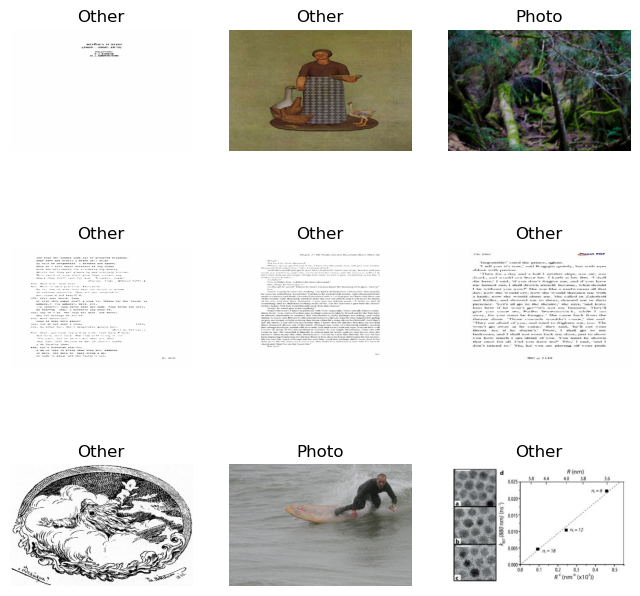

In [5]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_set.class_names[labels[i]])
        plt.axis("off")
plt.show()

## 1.5 Augmentation des données

In [28]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomTranslation((0.2, 0.5),(0.2, 0.5)),
  tf.keras.layers.RandomZoom((0.2, 0.5)),
  tf.keras.layers.RandomContrast((0.2,0.5))
])

augmented_train_set = train_set.map(lambda x, y: (data_augmentation(x, training=True), y))
print(augmented_train_set.cardinality())

tf.Tensor(259, shape=(), dtype=int64)


# 2. Modélisation des données
## 2.1 Définition du modèle

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

## 2.2 Compilation du modèle 

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

## 2.3 Entrainement du modèle

Epoch 1/10
259/259 [==============================] - 417s 2s/step - loss: 0.3423 - accuracy: 0.8217 - val_loss: 0.3783 - val_accuracy: 0.7869
Epoch 2/10
259/259 [==============================] - 427s 2s/step - loss: 0.3278 - accuracy: 0.8316 - val_loss: 0.3801 - val_accuracy: 0.8022
Epoch 3/10
259/259 [==============================] - 442s 2s/step - loss: 0.3177 - accuracy: 0.8417 - val_loss: 0.3615 - val_accuracy: 0.8148
Epoch 4/10
259/259 [==============================] - 502s 2s/step - loss: 0.3028 - accuracy: 0.8548 - val_loss: 0.4920 - val_accuracy: 0.7678
Epoch 5/10
259/259 [==============================] - 520s 2s/step - loss: 0.2907 - accuracy: 0.8628 - val_loss: 0.3209 - val_accuracy: 0.8425
Epoch 6/10
259/259 [==============================] - 504s 2s/step - loss: 0.2794 - accuracy: 0.8689 - val_loss: 0.3582 - val_accuracy: 0.8238
Epoch 7/10
259/259 [==============================] - 470s 2s/step - loss: 0.2653 - accuracy: 0.8791 - val_loss: 0.3932 - val_accuracy: 0.8259

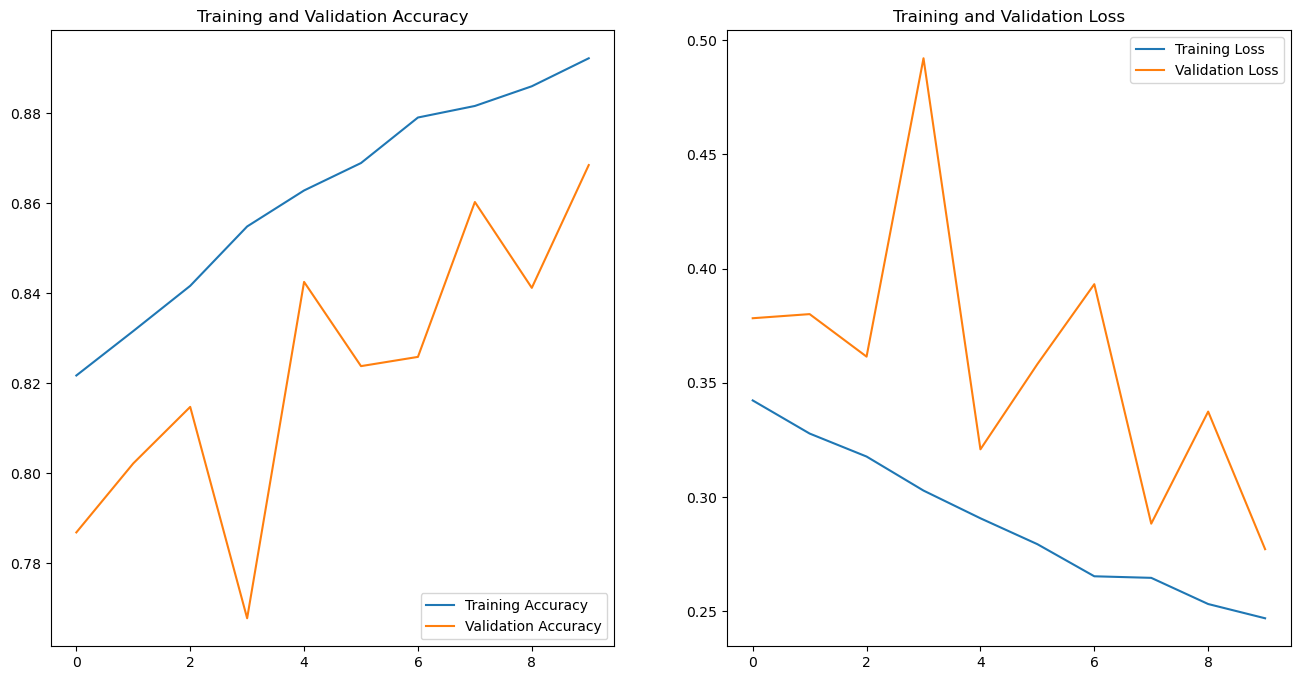

In [35]:
epochs = 10

with tf.device("/GPU:0"):
    history =  model.fit(
        augmented_train_set,
        validation_data=test_set,
        epochs=epochs
    )

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

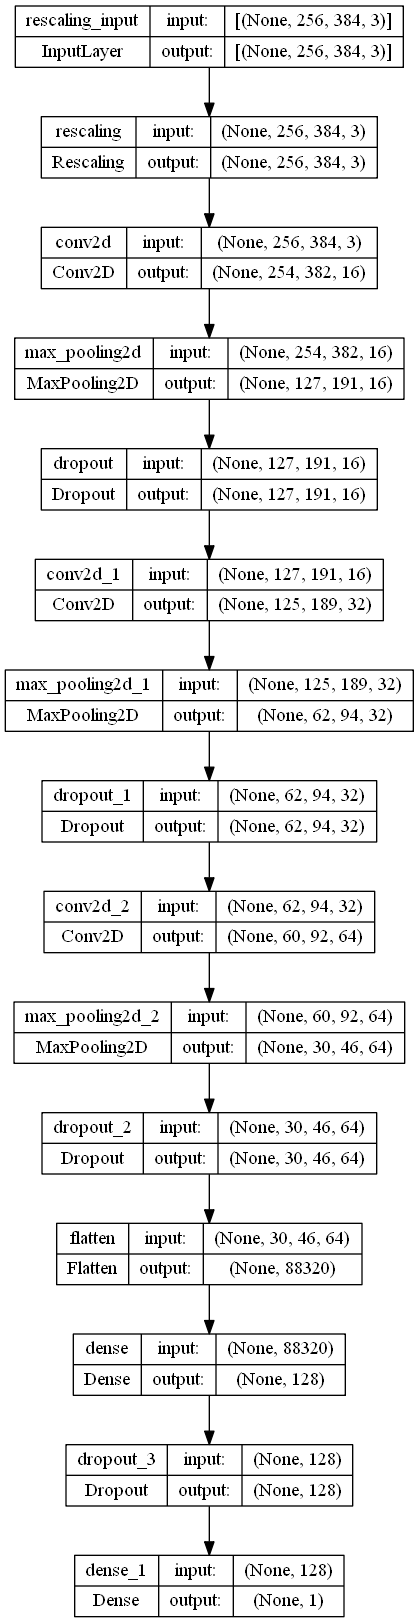

In [9]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)